# Comparison of scenarios

1. re

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import os

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
file_prefix = f'week'
outdir = '2021-01-19-107_30/'

n_int_steps = 6
nnodes = 107  # nodes
ndays_ocp = 30
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
setup_ocp = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    
os.makedirs('model_output/scenarios', exist_ok=True)

scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(29)}
scenarios.keys()

Loaded Italy Setup with 107 nodes.
Loaded Italy Setup with 107 nodes.


dict_keys(['U-r1-t125000-id0', 'L-r1-t125000-id1', 'U-r2-t125000-id2', 'L-r2-t125000-id3', 'U-r15-t125000-id4', 'L-r15-t125000-id5', 'U-r1-t250000-id6', 'L-r1-t250000-id7', 'U-r2-t250000-id8', 'L-r2-t250000-id9', 'U-r15-t250000-id10', 'L-r15-t250000-id11', 'U-r1-t479700-id12', 'L-r1-t479700-id13', 'U-r2-t479700-id14', 'L-r2-t479700-id15', 'U-r15-t479700-id16', 'L-r15-t479700-id17', 'U-r1-t1000000-id18', 'L-r1-t1000000-id19', 'U-r2-t1000000-id20', 'L-r2-t1000000-id21', 'U-r15-t1000000-id22', 'L-r15-t1000000-id23', 'U-r1-t2000000-id24', 'L-r1-t2000000-id25', 'U-r2-t2000000-id26', 'L-r2-t2000000-id27', 'U-r15-t2000000-id28'])

In [2]:
# Choose a subset of scenarios:
pick = 'L-r15'
scenarios = {k:v for (k,v) in scenarios.items() if pick in k}
print(len(scenarios))

4


In [5]:
scenarios_opt = {}
scenarios_baseline = {}
## Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    fname = f"{outdir}{file_prefix}-{'-'.join(scenario_name.split('-')[:-1])}-opt-{nnodes}_{ndays_ocp}.csv"
    #try:
    md = pd.read_csv(fname, index_col= 'date', parse_dates=True)
    print(f'YES {fname}')
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp - 1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = md[(md['place'] == nodename) & (md['comp'] == 'vacc')].iloc[k]['value']
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-opi-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    scenarios_opt[scenario_name] = scenario
    
    if scenario_name.split('-')[0] not in scenarios_baseline:
        control_initial = np.zeros((M, N))
        # Generate NO vaccination scenarios
        results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                  setup=setup,
                                                                  parameters=p,
                                                                  controls=control_initial,
                                                                  save_to=f'model_output/scenarios/{scenario_name}-novacc-{nnodes}_{ndays}',
                                                                  n_rk4_steps=n_int_steps)
        scenarios_baseline[scenario_name.split('-')[0]] = pd.read_csv(f'model_output/scenarios/{scenario_name}-novacc-{nnodes}_{ndays}.csv', 
                                                                     index_col= 'date', parse_dates=True)
        

#    except FileNotFoundError:
#        print(f'NOT {fname}')



YES 2021-01-19-107_30/week-L-r15-t125000-opt-107_30.csv


  3%|▎         | 3/89 [00:00<00:04, 20.34it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-opi-107_90


  3%|▎         | 3/89 [00:00<00:03, 22.23it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-novacc-107_90


100%|██████████| 89/89 [00:04<00:00, 21.27it/s]


YES 2021-01-19-107_30/week-L-r15-t250000-opt-107_30.csv


  2%|▏         | 2/89 [00:00<00:04, 18.98it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-opi-107_90


100%|██████████| 89/89 [00:04<00:00, 20.13it/s]


YES 2021-01-19-107_30/week-L-r15-t479700-opt-107_30.csv


  4%|▍         | 4/89 [00:00<00:04, 19.72it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-opi-107_90


100%|██████████| 89/89 [00:04<00:00, 20.27it/s]


YES 2021-01-19-107_30/week-L-r15-t1000000-opt-107_30.csv


  2%|▏         | 2/89 [00:00<00:04, 18.95it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-opi-107_90


100%|██████████| 89/89 [00:04<00:00, 20.03it/s]


In [6]:
# Generate alternatives:
# BY INCIDENCE: 
for scenario_name, scenario in scenarios_opt.items():
    nv = scenarios_baseline[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp -1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-inc-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

# BY Suceptibility: 
for scenario_name, scenario in scenarios_opt.items():
    nv = scenarios_baseline[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['S'])].loc[str(setup.start_date)]
    incid.set_index('placeID', inplace=True)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp -1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-sus-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    

    
# BY POPULATION 
for scenario_name, scenario in scenarios_opt.items():
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp -1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            pop_nd = setup.pop_node[nd]
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * pop_nd / setup.pop_node.sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-pop-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    
# BY FUTURE NEW CASES
for scenario_name, scenario in scenarios_opt.items():
    nv = scenarios_baseline[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['E', 'I', 'A'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(ndays_ocp - 1):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'model_output/scenarios/{scenario_name}-cas-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    
#TODO: Centrality based and R0 based

  3%|▎         | 3/89 [00:00<00:04, 20.07it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-inc-107_90


  2%|▏         | 2/89 [00:00<00:04, 19.69it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-inc-107_90


  2%|▏         | 2/89 [00:00<00:04, 19.91it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-inc-107_90


  3%|▎         | 3/89 [00:00<00:04, 20.06it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-inc-107_90


  2%|▏         | 2/89 [00:00<00:05, 17.00it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-sus-107_90


  4%|▍         | 4/89 [00:00<00:04, 19.79it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-sus-107_90


  3%|▎         | 3/89 [00:00<00:04, 20.59it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-sus-107_90


  3%|▎         | 3/89 [00:00<00:04, 21.29it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-sus-107_90


  2%|▏         | 2/89 [00:00<00:04, 19.28it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-pop-107_90


  3%|▎         | 3/89 [00:00<00:04, 19.85it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-pop-107_90


  2%|▏         | 2/89 [00:00<00:04, 18.36it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-pop-107_90


  3%|▎         | 3/89 [00:00<00:04, 20.22it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-pop-107_90


  2%|▏         | 2/89 [00:00<00:04, 19.41it/s]

===> Integrating for model_output/scenarios/L-r15-t125000-id5-cas-107_90


  2%|▏         | 2/89 [00:00<00:04, 19.57it/s]

===> Integrating for model_output/scenarios/L-r15-t250000-id11-cas-107_90


  3%|▎         | 3/89 [00:00<00:04, 19.95it/s]

===> Integrating for model_output/scenarios/L-r15-t479700-id17-cas-107_90


  2%|▏         | 2/89 [00:00<00:04, 19.80it/s]

===> Integrating for model_output/scenarios/L-r15-t1000000-id23-cas-107_90


100%|██████████| 89/89 [00:04<00:00, 19.79it/s]


In [8]:
scn_results = pd.DataFrame(columns=['newdoseperweek', 'method', 'infected'])
methods = ['opi', 'inc', 'pop', 'sus', 'cas'] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios_opt.items():
        maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
        dosesperweek = int(scenario_name.split('-')[2][1:])
        ratepermonth = int(scenario_name.split('-')[1][1:])*1e6
        md = pd.read_csv(f'model_output/scenarios/{scenario_name}-{met}-{nnodes}_{ndays}.csv', index_col= 'date', parse_dates=True)
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()
        doses = md[md['comp']=='vacc']['value'].sum()
        nv = scenarios_baseline[scenario_name.split('-')[0]]
        baseline_infected = nv[(nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])) & (nv.index == str(setup.end_date))]['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'newdoseperweek':[dosesperweek],
                                                                      'method': [met],
                                                                      'infected':[infected],
                                                                       'doses': [doses],
                                                                       'scenario-beta': [scenario_name.split('-')[0]],
                                                                       'scenario-rate': [scenario_name.split('-')[1]],
                                                                       'scenario-tot': [scenario_name.split('-')[2]],
                                                                       'averted': baseline_infected - infected
                                                                     })])                      
   
scn_results['avertedpervacc'] = scn_results['averted']/scn_results['doses']

#scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('opi', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('cas', 'Future Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)
scn_results.replace('sus', 'Susceptibility', inplace=True)

In [11]:
scn_results

,newdoseperweek,method,infected,doses,scenario-beta,scenario-rate,scenario-tot,averted,avertedpervacc
0,125000,Optimal,4.696594e+06,5.000000e+05,L,r15,t125000,120164.356924,0.240329
0,250000,Optimal,4.658723e+06,1.000000e+06,L,r15,t250000,158034.583183,0.158035
0,479700,Optimal,4.615159e+06,1.918800e+06,L,r15,t479700,201598.970297,0.105065
0,1000000,Optimal,4.554874e+06,4.000000e+06,L,r15,t1000000,261883.988224,0.065471
0,125000,Incidence,4.791159e+06,4.992082e+05,L,r15,t125000,25599.447628,0.051280
0,250000,Incidence,4.766807e+06,9.984160e+05,L,r15,t250000,49950.628637,0.050030
0,479700,Incidence,4.722011e+06,1.915480e+06,L,r15,t479700,94746.848741,0.049464
0,1000000,Incidence,4.642341e+06,3.988904e+06,L,r15,t1000000,174416.692916,0.043725
0,125000,Population,4.790005e+06,4.991642e+05,L,r15,t125000,26753.299468,0.053596
0,250000,Population,4.762013e+06,9.980850e+05,L,r15,t250000,54744.910884,0.054850


In [16]:
scn_results[scn_results['scenario-tot']=='t125000']

,newdoseperweek,method,infected,doses,scenario-beta,scenario-rate,scenario-tot,averted,avertedpervacc
0,125000,Optimal,4.696594e+06,500000.000000,L,r15,t125000,120164.356924,0.240329
0,125000,Incidence,4.791159e+06,499208.150398,L,r15,t125000,25599.447628,0.051280
0,125000,Population,4.790005e+06,499164.188892,L,r15,t125000,26753.299468,0.053596
0,125000,Susceptibility,4.795634e+06,499199.908700,L,r15,t125000,21124.238855,0.042316
0,125000,Future Incidence,4.755953e+06,499179.233277,L,r15,t125000,60805.066117,0.121810


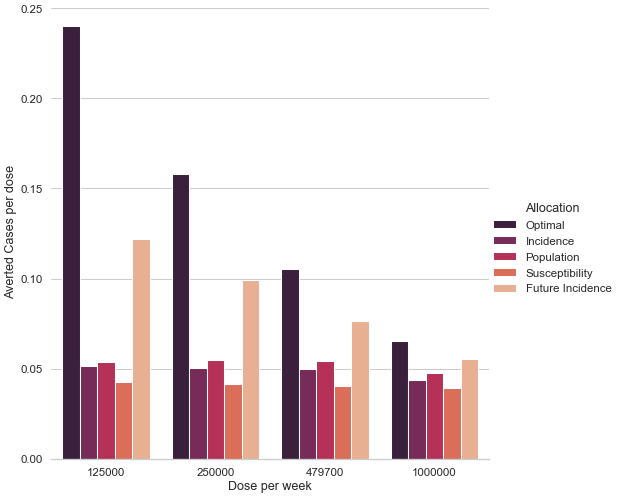

In [15]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=scn_results,#[(scn_results['scenario-rate']=='r2') & (scn_results['scenario-beta']=='U')],
    kind="bar",
    x="newdoseperweek",
    y="avertedpervacc", 
    #y="averted",
    hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Dose per week", "Averted Cases per dose")
g.legend.set_title("Allocation")
#g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])

g.fig.savefig('figures/scenarios.pdf') 

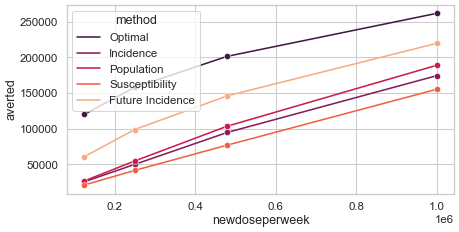

In [12]:
g = sns.lineplot(
    data=scn_results, 
    x="newdoseperweek", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

In [ ]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scn_results, kind="bar",
    x="method", 
    #y="avertedpervacc", 
    #x='total_vacc',
    y="averted",
    hue="method",
    col="newdoseperweek",
    palette="viridis",
    #alpha=.9, 
    height=5,
    aspect = .5,
    #width = 10
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Strategy", "Averted Cases")
#g.legend.set_title("Allocation")
g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['newdoseperweek'].unique())])
(g.set_axis_labels("", "Averted Cases")
#.set_xticklabels(["Men", "Women", "Children"])
.set_titles("{col_name}")
#.set(ylim=(0, 1))
.despine(left=True))
g.set_xticklabels(rotation=-90)